## **Training**

### **XGBoost**

In [25]:
# Create features
N_day_lags = 3

# Initialize the feature processor
processor = FeatureProcessor()

# Process the features
features = processor.process_features(data = train.copy(),
                      client = client.copy(),
                      historical_weather = historical_weather.copy(),
                      forecast_weather = forecast_weather.copy(),
                      electricity = electricity.copy(),
                      gas = gas.copy(),
                     )

df = create_revealed_targets_train(features.copy(), N_day_lags = N_day_lags)
print(f'There are {df.shape[1]} features: {list(df.columns)}')

datetime         datetime64[ns]
county                    int64
data_block_id             int64
dtype: object
datetime         datetime64[ns]
county                  float64
data_block_id             int64
dtype: object
There are 59 features: ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'date', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'date_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'hour_h', 'hours_ahead_f_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f

In [32]:
# List of columns to be removed
no_features = ['date',
               'datetime',
               'forecast_date_electricity',
               'date_client',
               'origin_date_electricity',
               'forecast_date_gas',
               'origin_date_gas',
               'row_id', 
               'prediction_unit_id']

remove_columns = ['target']

# Remove the specified columns from the DataFrame
df_sorted = df.sort_values(by=["datetime"], ascending=True)
df_dropped = df_sorted.drop(columns=no_features)
features = [f for f in df_dropped.columns if f not in remove_columns]
target = ['target']
print(f'There are {df_dropped.shape[1]} features: {list(df_dropped.columns)}')

There are 50 features: ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'data_block_id', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'hour_h', 'hours_ahead_f_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f_mean', 'cloudcover_mid_f_mean', 'cloudcover_total_f_mean', '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean', 'direct_solar_radiation_f_mean', 'surface_solar_radiation_downwards_f_mean', 'snowfall_f_mean', 'total_precipitation_f_mean', 'euros_per_mwh_electricity', 

In [33]:
df_RGBoost = df_dropped.dropna(subset=target).reset_index(drop=True)

train_block_id = list(range(0, 446))
val_block_id = list(range(446, 542))
test_block_id = list(range(542, 638))

tr = df_RGBoost[df_RGBoost['data_block_id'].isin(train_block_id)]
val = df_RGBoost[df_RGBoost['data_block_id'].isin(val_block_id)] 
test = df_RGBoost[df_RGBoost['data_block_id'].isin(test_block_id)] 
        
x_train = []
y_train = []
x_val = []
y_val = []

x_train_og = tr[features]
y_train_og = tr[target]
x_val_og = val[features]
y_val_og = val[target]
        
x_train = np.array(x_train_og).astype('float32')
y_train = np.array(y_train_og).astype('float32')
x_val = np.array(x_val_og).astype('float32')
y_val = np.array(y_val_og).astype('float32')

In [34]:
clf = xgb.XGBRegressor(
                        device = device,
                        enable_categorical=True,
                        objective = 'reg:absoluteerror',
                        n_estimators = 1500,
                        early_stopping_rounds=100,
                        learning_rate=0.1,
                        max_depth=None,
                       )

In [35]:
clf.fit(X = x_train, 
        y = y_train, 
        eval_set = [(x_train, y_train), (x_val, y_val)], 
        verbose=False #True
       )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=100,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

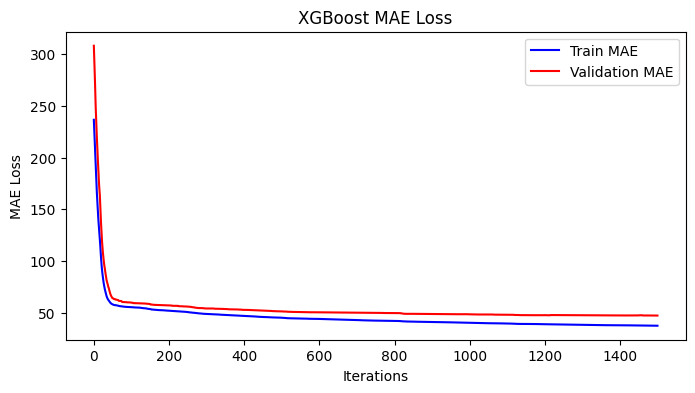

Early stopping on best iteration #1499 with MAE error on validation set of 47.37
with MAE error on training set of 37.56
last train MAE: 37.56
last val MAE: 47.37


In [36]:
# Plot RMSE
results = clf.evals_result()
train_mae, val_mae = results["validation_0"]["mae"], results["validation_1"]["mae"]
x_values = range(0, len(train_mae))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_values, train_mae, "b-", label="Train MAE")
ax.plot(x_values, val_mae, "r-", label="Validation MAE")
ax.legend()
plt.ylabel("MAE Loss")
plt.xlabel("Iterations")
plt.title("XGBoost MAE Loss")
plt.show()
print(f'Early stopping on best iteration #{clf.best_iteration} with MAE error on validation set of {clf.best_score:.2f}')
print(f'with MAE error on training set of {train_mae[clf.best_iteration]:.2f}')

print(f'last train MAE: {train_mae[-1]:.2f}')
print(f'last val MAE: {val_mae[-1]:.2f}')

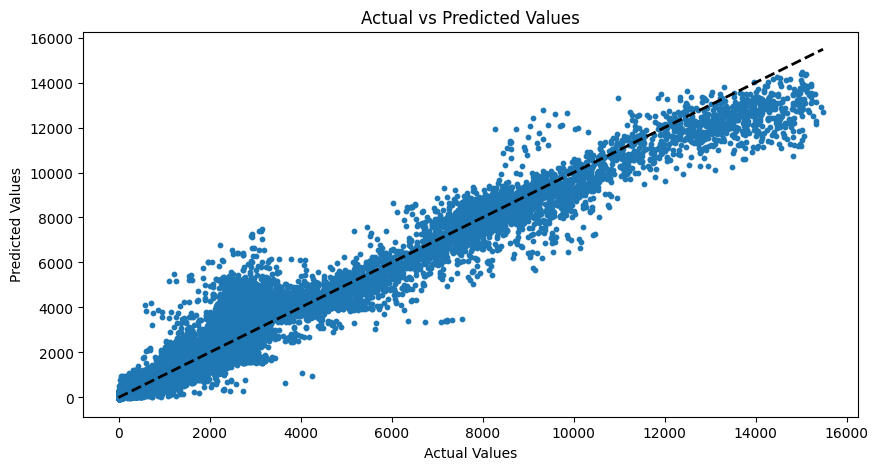

In [37]:
# Generate predictions
y_pred = clf.predict(x_val)

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_val, y_pred, s=10)  # Scatter plot for actual vs predictions
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)  # Diagonal line for perfect predictions
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

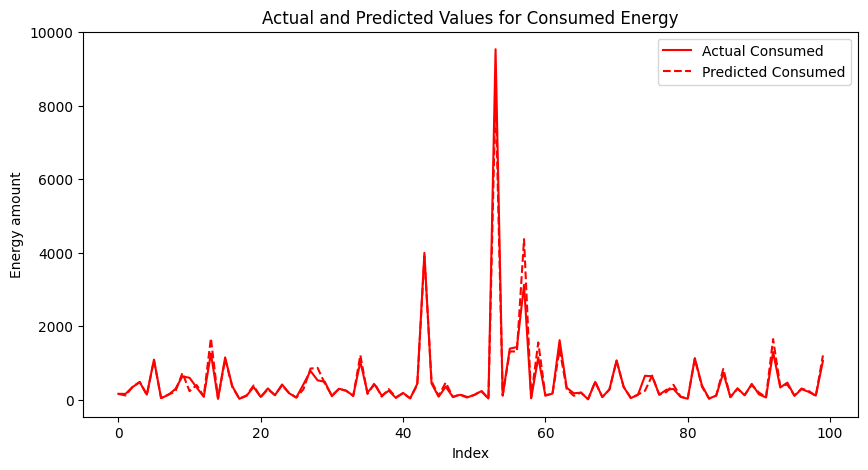

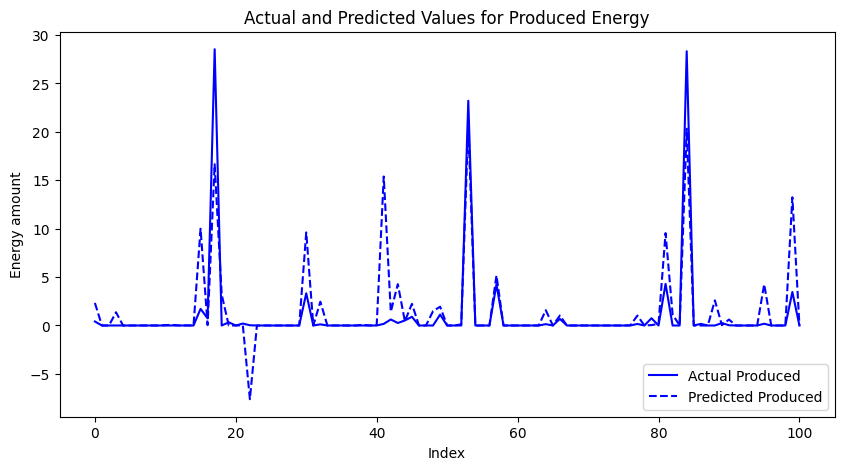

In [38]:
# Choose the range of indices to focus on
start_index = 90000  # Replace with your actual start index
end_index = 90200    # Replace with your actual end index

# Create a boolean mask for the consumed and produced energy within the specified range
indices = np.arange(len(y_val))

# Create boolean masks based on the conditions
consumed_range = (x_val_og['is_consumption'] == 1) & (indices >= start_index) & (indices <= end_index)
produced_range = (x_val_og['is_consumption'] == 0) & (indices >= start_index) & (indices <= end_index)

# Plot for consumed energy in the specified range
plt.figure(figsize=(10, 5))
plt.plot(y_val[consumed_range], 'r-', label='Actual Consumed')
plt.plot(y_pred[consumed_range], 'r--', label='Predicted Consumed')
plt.title('Actual and Predicted Values for Consumed Energy')
plt.xlabel('Index')
plt.ylabel('Energy amount')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_val[produced_range], 'b-', label='Actual Produced')
plt.plot(y_pred[produced_range], 'b--', label='Predicted Produced')
plt.title('Actual and Predicted Values for Produced Energy')
plt.xlabel('Index')
plt.ylabel('Energy amount')
plt.legend()
plt.show()

### **MLP**

In [42]:
train_block_id = list(range(0, 446))
val_block_id = list(range(446, 542))
test_block_id = list(range(542, 638))

df_FC = df[df['target'].notnull()].reset_index(drop=True)
tr = df_FC[df_FC['data_block_id'].isin(train_block_id)]
val = df_FC[df_FC['data_block_id'].isin(val_block_id)] 
test = df_FC[df_FC['data_block_id'].isin(test_block_id)] 
        
x_train = []
y_train = []
x_val = []
y_val = []

x_train_og = tr[features]
y_train_og = tr[target]
x_val_og = val[features]
y_val_og = val[target]
        
x_train = np.array(x_train_og).astype('float32')
y_train = np.array(y_train_og).astype('float32')
x_val = np.array(x_val_og).astype('float32')
y_val = np.array(y_val_og).astype('float32')
        
x_train = np.nan_to_num(x_train)
x_val = np.nan_to_num(x_val)

In [44]:
def train(x_train, y_train, x_val, y_val):
    
        model = {
            "model": None,
            "history": None,
            "y_pred": None}
        
        model['model'] = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, input_shape=(len(features),), activation='relu'),
            tf.keras.layers.Dense(64, input_shape=(len(features),), activation='relu'),
            tf.keras.layers.Dense(128, input_shape=(len(features),), activation='relu'),
            tf.keras.layers.Dense(256, input_shape=(len(features),), activation='relu'),
            #tf.keras.layers.Dense(32, activation='relu'),
            #tf.keras.layers.Dropout(0.1),
            #tf.keras.layers.Dense(64, activation='relu'),
            #tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
        model['model'].compile(optimizer='adam', loss='mae', metrics=['mae'])
        model['history'] = model['model'].fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val), callbacks=[early_stop])
        y_pred = model['model'].predict(x_val)
        model['y_pred'] = y_pred
        model['y_val'] = y_val
        
        return model, y_pred

model, y_pred = train(x_train, y_train, x_val, y_val)

Epoch 1/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 75.7255 - mae: 75.7255 - val_loss: 58.4502 - val_mae: 58.4502
Epoch 2/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 65.8195 - mae: 65.8195 - val_loss: 58.6419 - val_mae: 58.6419
Epoch 3/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 61.9429 - mae: 61.9429 - val_loss: 55.6603 - val_mae: 55.6603
Epoch 4/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 59.9411 - mae: 59.9411 - val_loss: 56.6496 - val_mae: 56.6496
Epoch 5/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 57.9355 - mae: 57.9355 - val_loss: 51.8805 - val_mae: 51.8805
Epoch 6/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 56.6737 - mae: 56.6737 - val_loss: 52.3089 - val_mae: 52.3089
Epoch 7/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 54.8558 - mae: 54.8558 - val_loss: 52.4393 - val_mae: 52.4393
Epoch 8/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 54.0191 - mae: 54.0191 - val_loss: 49.2324 - v

<Figure size 640x480 with 0 Axes>

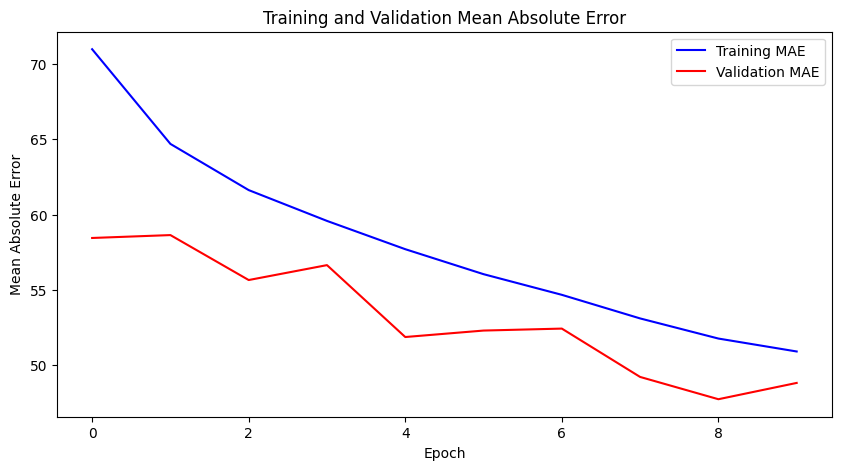

In [45]:
plt.figure()
plt.figure(figsize=(10, 5))
plt.plot(model["history"].history['mae'], 'b', label='Training MAE')
plt.plot(model["history"].history['val_mae'],'r', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show() 

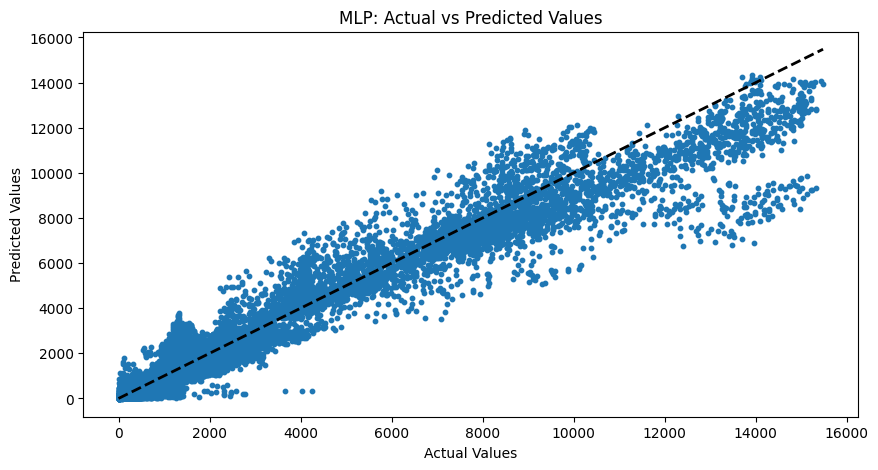

In [46]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_val, y_pred, s=10)  # Scatter plot for actual vs predictions
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)  # Diagonal line for perfect predictions
plt.title('MLP: Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

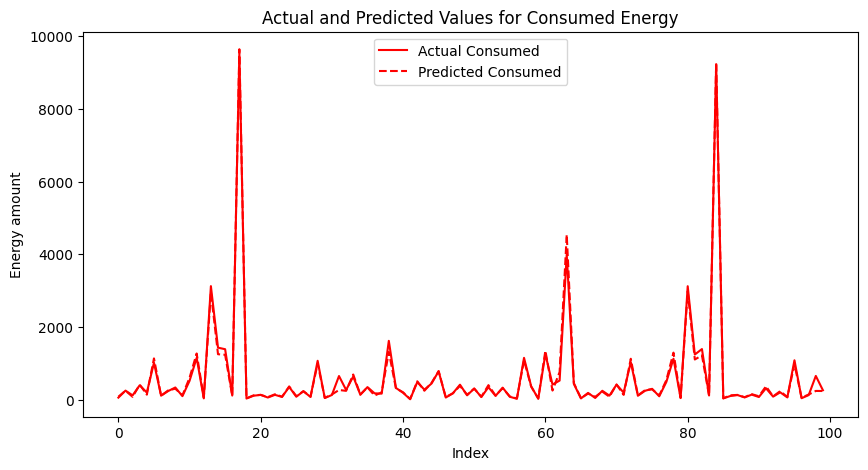

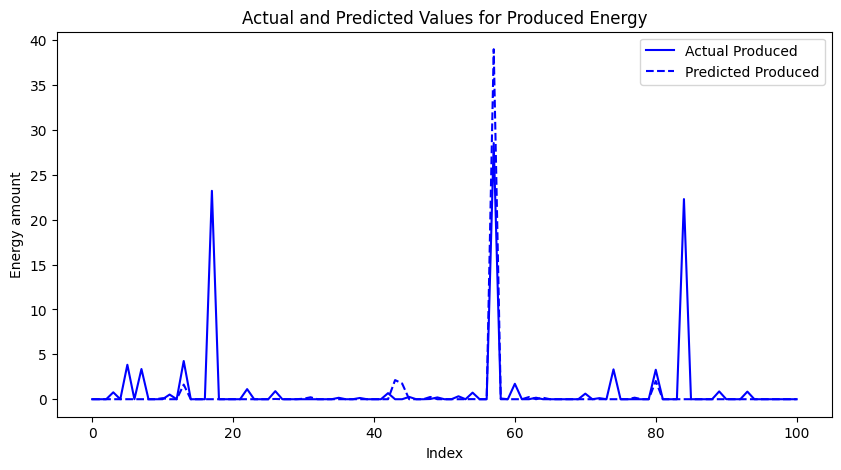

In [47]:
# Choose the range of indices to focus on
start_index = 90000  # Replace with your actual start index
end_index = 90200    # Replace with your actual end index

# Create a boolean mask for the consumed and produced energy within the specified range
indices = np.arange(len(y_val))

# Create boolean masks based on the conditions
consumed_range = (x_val_og['is_consumption'] == 1) & (indices >= start_index) & (indices <= end_index)
produced_range = (x_val_og['is_consumption'] == 0) & (indices >= start_index) & (indices <= end_index)

# Plot for consumed energy in the specified range
plt.figure(figsize=(10, 5))
plt.plot(y_val[consumed_range], 'r-', label='Actual Consumed')
plt.plot(y_pred[consumed_range], 'r--', label='Predicted Consumed')
plt.title('Actual and Predicted Values for Consumed Energy')
plt.xlabel('Index')
plt.ylabel('Energy amount')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_val[produced_range], 'b-', label='Actual Produced')
plt.plot(y_pred[produced_range], 'b--', label='Predicted Produced')
plt.title('Actual and Predicted Values for Produced Energy')
plt.xlabel('Index')
plt.ylabel('Energy amount')
plt.legend()
plt.show()